# 📦 Phase 1 — Data Preparation
## Olist Pricing Intelligence

---

**Objectif :** Charger, nettoyer, joindre et enrichir les tables du dataset Olist Brazilian E-commerce pour produire un dataset analytique unique, prêt à l'emploi pour les analyses de pricing (Phase 2) et le dashboard Power BI (Phase 3).

**Dataset source :** [Olist Brazilian E-commerce — Kaggle](https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce)

> ⚠️ **Prérequis :** télécharger les CSV depuis Kaggle et les placer dans `data/raw/` avant d'exécuter ce notebook.

**Tables utilisées :**

| Table | Rôle |
|---|---|
| `olist_orders_dataset` | Commandes, statuts, dates |
| `olist_order_items_dataset` | Prix, fret, produit par ligne |
| `olist_products_dataset` | Caractéristiques produit |
| `olist_product_category_name_translation` | Traduction catégories (PT → EN) |
| `olist_order_reviews_dataset` | Avis et scores clients |
| `olist_sellers_dataset` | Localisation vendeurs |
| `olist_customers_dataset` | État géographique du client |
| `olist_order_payments_dataset` | Mode de paiement, versements |

**Tables exclues volontairement :**

| Table | Raison |
|---|---|
| `olist_geolocation_dataset` | Coordonnées GPS par code postal — hors scope pricing |

**Output :** `data/processed/olist_pricing_dataset.csv` + `olist_pricing_dataset.xlsx`

---

## Table des matières

1. [Imports & Configuration](#1-imports)
2. [Chargement des données](#2-chargement)
3. [Analyse Exploratoire des données](#3-qualite)
4. [Nettoyage](#4-nettoyage)
5. [Jointures](#5-jointures)
6. [Feature Engineering](#6-features)
7. [Visualisations de validation](#7-viz)
8. [Export](#8-export)

---
## 1. Imports & Configuration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import os
import warnings
warnings.filterwarnings("ignore")

# ── Style global ──────────────────────────────────────────
plt.rcParams.update({
    "figure.facecolor":  "#F8F9FA",
    "axes.facecolor":    "#FFFFFF",
    "axes.spines.top":   False,
    "axes.spines.right": False,
    "font.family":       "sans-serif",
    "axes.titlesize":    13,
    "axes.titleweight":  "bold",
    "axes.labelsize":    11,
    "xtick.labelsize":   10,
    "ytick.labelsize":   10,
})

# ── Palette Okabe-Ito (daltonisme-friendly, standard scientifique) ──
# Source : Okabe & Ito (2008) — https://jfly.uni-koeln.de/color/
PALETTE = [
    "#E69F00",  # Orange
    "#56B4E9",  # Bleu ciel
    "#009E73",  # Vert
    "#F0E442",  # Jaune
    "#0072B2",  # Bleu foncé
    "#D55E00",  # Vermillon
    "#CC79A7",  # Rose/mauve
    "#000000",  # Noir
]

print("✅ Configuration OK — Palette Okabe-Ito chargée")
print(f"   Couleurs disponibles : {len(PALETTE)}")

# ── Chemins ───────────────────────────────────────────────
DATA_RAW = "../data/raw/"
DATA_OUT = "../data/processed/"
IMG_OUT  = "../outputs/"

os.makedirs(DATA_OUT, exist_ok=True)
os.makedirs(IMG_OUT,  exist_ok=True)

# ── Taux de change ────────────────────────────────────────
# Mettre à jour avec le taux souhaité avant exécution
# Source de référence : https://www.ecb.europa.eu/stats/policy_and_exchange_rates/euro_reference_exchange_rates/html/eurofxref-graph-brl.en.html
BRL_TO_EUR = 0.16   # 1 R$ = 0.17 € (taux indicatif — à ajuster)

print("✅ Configuration OK")
print(f"   Taux de change appliqué : 1 R$ = {BRL_TO_EUR} €")

✅ Configuration OK — Palette Okabe-Ito chargée
   Couleurs disponibles : 8
✅ Configuration OK
   Taux de change appliqué : 1 R$ = 0.16 €


---
## 2. Chargement des données

In [2]:
def load_csv(filename):
    """Charge un CSV depuis data/raw/. Lève une erreur explicite si le fichier est absent."""
    path = os.path.join(DATA_RAW, filename)
    if not os.path.exists(path):
        raise FileNotFoundError(
            f"Fichier introuvable : {path}\n"
            f"  → Télécharge le dataset sur https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce\n"
            f"  → Place les CSV dans le dossier data/raw/"
        )
    df = pd.read_csv(path)
    print(f"  ✅ {filename:<55} {len(df):>8,} lignes")
    return df

print("Chargement des tables Olist...\n")
orders      = load_csv("olist_orders_dataset.csv")
order_items = load_csv("olist_order_items_dataset.csv")
products    = load_csv("olist_products_dataset.csv")
categories  = load_csv("product_category_name_translation.csv")
reviews     = load_csv("olist_order_reviews_dataset.csv")
sellers     = load_csv("olist_sellers_dataset.csv")
customers   = load_csv("olist_customers_dataset.csv")
payments    = load_csv("olist_order_payments_dataset.csv")

Chargement des tables Olist...

  ✅ olist_orders_dataset.csv                                  99,441 lignes
  ✅ olist_order_items_dataset.csv                            112,650 lignes
  ✅ olist_products_dataset.csv                                32,951 lignes
  ✅ product_category_name_translation.csv                         71 lignes
  ✅ olist_order_reviews_dataset.csv                           99,224 lignes
  ✅ olist_sellers_dataset.csv                                  3,095 lignes
  ✅ olist_customers_dataset.csv                               99,441 lignes
  ✅ olist_order_payments_dataset.csv                         103,886 lignes


---
## 3. Analyse Exploratoire des Données (EDA)

EDA des valeurs manquantes, des types et des plages de valeurs sur les colonnes clés.

In [3]:
def quality_report(df, name):
    """Affiche un rapport de qualité concis pour un DataFrame."""
    missing = df.isnull().sum()
    missing = missing[missing > 0]
    print(f"\n{'─'*55}")
    print(f"  {name} — {len(df):,} lignes × {df.shape[1]} colonnes")
    if len(missing):
        print("  Valeurs manquantes :")
        for col, cnt in missing.items():
            print(f"    • {col}: {cnt:,} ({cnt/len(df)*100:.1f}%)")
    else:
        print("  Valeurs manquantes : ✅ aucune")

for df, name in [
    (orders,      "orders"),
    (order_items, "order_items"),
    (products,    "products"),
    (reviews,     "reviews"),
    (customers,   "customers"),
    (payments,    "payments"),
]:
    quality_report(df, name)


───────────────────────────────────────────────────────
  orders — 99,441 lignes × 8 colonnes
  Valeurs manquantes :
    • order_approved_at: 160 (0.2%)
    • order_delivered_carrier_date: 1,783 (1.8%)
    • order_delivered_customer_date: 2,965 (3.0%)

───────────────────────────────────────────────────────
  order_items — 112,650 lignes × 7 colonnes
  Valeurs manquantes : ✅ aucune

───────────────────────────────────────────────────────
  products — 32,951 lignes × 9 colonnes
  Valeurs manquantes :
    • product_category_name: 610 (1.9%)
    • product_name_lenght: 610 (1.9%)
    • product_description_lenght: 610 (1.9%)
    • product_photos_qty: 610 (1.9%)
    • product_weight_g: 2 (0.0%)
    • product_length_cm: 2 (0.0%)
    • product_height_cm: 2 (0.0%)
    • product_width_cm: 2 (0.0%)

───────────────────────────────────────────────────────
  reviews — 99,224 lignes × 7 colonnes
  Valeurs manquantes :
    • review_comment_title: 87,656 (88.3%)
    • review_comment_message: 58,247 (

In [4]:
# Distribution des statuts de commande
print("Distribution des statuts de commande :")
print(orders["order_status"].value_counts(normalize=True).mul(100).round(1).to_string())

Distribution des statuts de commande :
order_status
delivered      97.0
shipped         1.1
canceled        0.6
unavailable     0.6
invoiced        0.3
processing      0.3
created         0.0
approved        0.0


In [5]:
# Distribution des modes de paiement
print("Distribution des modes de paiement :")
print(payments["payment_type"].value_counts(normalize=True).mul(100).round(1).to_string())

print("\nStatistiques — nombre de versements :")
print(payments["payment_installments"].describe().round(1).to_string())

Distribution des modes de paiement :
payment_type
credit_card    73.9
boleto         19.0
voucher         5.6
debit_card      1.5
not_defined     0.0

Statistiques — nombre de versements :
count    103886.0
mean          2.9
std           2.7
min           0.0
25%           1.0
50%           1.0
75%           4.0
max          24.0


In [6]:
# Plages de prix — détection d'anomalies
print("Statistiques descriptives — prix & fret :")
order_items[["price", "freight_value"]].describe().round(2)

Statistiques descriptives — prix & fret :


,price,freight_value
count,112650.00,112650.00
mean,120.65,19.99
std,183.63,15.81
min,0.85,0.00
25%,39.90,13.08
50%,74.99,16.26
75%,134.90,21.15
max,6735.00,409.68


---
## 4. Nettoyage

Règles appliquées :
- **Commandes** : on ne conserve que les commandes `delivered` (statut fiable pour l'analyse pricing)
- **Prix** : suppression des lignes avec `price <= 0` ou `price > 10 000` (outliers aberrants)
- **Paiements** : exclusion du type `not_defined` (données corrompues)
- **Doublons** : suppression stricte sur toutes les tables

In [7]:
# ── Commandes livrées uniquement ──────────────────────────
orders["order_purchase_timestamp"] = pd.to_datetime(
    orders["order_purchase_timestamp"], errors="coerce"
)
orders_clean = orders[orders["order_status"] == "delivered"].copy()
print(f"Commandes livrées : {len(orders_clean):,} / {len(orders):,} "
      f"({len(orders_clean)/len(orders)*100:.1f}%)")

# ── Filtres order_items ───────────────────────────────────
n_before = len(order_items)
order_items = order_items.dropna(subset=["price", "product_id"])
order_items = order_items[(order_items["price"] > 0) & (order_items["price"] < 10_000)]
order_items = order_items[order_items["freight_value"] >= 0]
order_items = order_items.drop_duplicates()
print(f"Items valides     : {len(order_items):,} / {n_before:,} "
      f"({n_before - len(order_items)} supprimés)")

# ── Nettoyage payments ────────────────────────────────────
n_before = len(payments)
payments = payments[payments["payment_type"] != "not_defined"]
payments = payments.drop_duplicates()
print(f"Paiements valides : {len(payments):,} / {n_before:,} "
      f"({n_before - len(payments)} supprimés)")

print("\n✅ Nettoyage terminé")

Commandes livrées : 96,478 / 99,441 (97.0%)
Items valides     : 112,650 / 112,650 (0 supprimés)
Paiements valides : 103,883 / 103,886 (3 supprimés)

✅ Nettoyage terminé


---
## 5. Jointures

On construit le dataset analytique unique en joinant toutes les tables autour de `order_id` et `product_id`.

```
order_items
    ├── LEFT JOIN  products          → product_category_name, product_weight_g
    ├── LEFT JOIN  categories        → product_category_name_english
    ├── INNER JOIN orders_clean      → order_purchase_timestamp (filtre livré)
    ├── LEFT JOIN  reviews_agg       → review_score_avg
    ├── LEFT JOIN  sellers           → seller_state
    ├── LEFT JOIN  customers         → customer_state
    └── LEFT JOIN  payments_agg      → payment_type (dominant), payment_installments (max)
```

In [8]:
# ── Agrégation reviews (score moyen par commande) ─────────
reviews_agg = (
    reviews.groupby("order_id")["review_score"]
    .mean()
    .reset_index()
    .rename(columns={"review_score": "review_score_avg"})
)

# ── Agrégation payments par commande ─────────────────────
# payment_type dominant + nombre max de versements
payments_agg = (
    payments.groupby("order_id")
    .agg(
        payment_type=("payment_type", lambda x: x.value_counts().index[0]),
        payment_installments=("payment_installments", "max"),
        payment_value=("payment_value", "sum"),
    )
    .reset_index()
)

# ── Jointures successives ─────────────────────────────────
df = (
    order_items
    .merge(products[["product_id", "product_category_name", "product_weight_g"]],
           on="product_id", how="left")
    .merge(categories,
           on="product_category_name", how="left")
    .merge(orders_clean[["order_id", "order_purchase_timestamp", "customer_id"]],
           on="order_id", how="inner")
    .merge(reviews_agg,
           on="order_id", how="left")
    .merge(sellers[["seller_id", "seller_state"]],
           on="seller_id", how="left")
    .merge(customers[["customer_id", "customer_state"]],
           on="customer_id", how="left")
    .merge(payments_agg,
           on="order_id", how="left")
)

print(f"Dataset après jointures : {len(df):,} lignes × {df.shape[1]} colonnes")
df.head(3)

Dataset après jointures : 110,197 lignes × 18 colonnes


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_weight_g,product_category_name_english,order_purchase_timestamp,customer_id,review_score_avg,seller_state,customer_state,payment_type,payment_installments,payment_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29,cool_stuff,650.0,cool_stuff,2017-09-13 08:59:02,3ce436f183e68e07877b285a838db11a,5.0,SP,RJ,credit_card,2.0,72.19
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93,pet_shop,30000.0,pet_shop,2017-04-26 10:53:06,f6dd3ec061db4e3987629fe6b26e5cce,4.0,SP,SP,credit_card,3.0,259.83
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.0,17.87,moveis_decoracao,3050.0,furniture_decor,2018-01-14 14:33:31,6489ae5e4333f3693df5ad4372dab6d3,5.0,MG,MG,credit_card,5.0,216.87


---
## 6. Feature Engineering

Création des variables analytiques orientées **pricing** :

| Variable | Description |
|---|---|
| `total_price` | Prix produit + fret (coût réel pour le client) |
| `freight_ratio` | Part du fret dans le total (indicateur compétitivité livraison) |
| `estimated_margin` | Marge estimée (hypothèse COGS = 55% du prix) |
| `price_segment` | Segmentation en 5 gammes de prix |
| `is_installment` | Achat en plusieurs fois (booléen) — signal prix élevé |
| `same_state_delivery` | Vendeur et client dans le même état — proxy coût logistique |
| `price_eur` / `total_price_eur` / ... | Colonnes converties en € (taux configurable en Section 1) |
| `price_segment_eur` | Segmentation en gammes de prix converties en € |
| `year / month / quarter` | Dimensions temporelles pour Power BI |

In [9]:
# ── Dimensions temporelles ────────────────────────────────
df["year"]        = df["order_purchase_timestamp"].dt.year
df["month"]       = df["order_purchase_timestamp"].dt.month
df["quarter"]     = df["order_purchase_timestamp"].dt.quarter
df["month_label"] = df["order_purchase_timestamp"].dt.to_period("M").astype(str)

# ── Métriques de prix ─────────────────────────────────────
df["total_price"]   = df["price"] + df["freight_value"]
df["freight_ratio"] = (df["freight_value"] / df["total_price"]).round(4)

# ── Marge estimée ─────────────────────────────────────────
# En production : cette valeur viendrait du catalogue / ERP
COGS_RATIO = 0.55
df["estimated_margin"]     = (df["price"] * (1 - COGS_RATIO)).round(2)
df["estimated_margin_pct"] = round(1 - COGS_RATIO, 2)

# ── Segment de prix ───────────────────────────────────────
bins   = [0, 50, 150, 300, 500, 10_000]
labels = ["< 50 R$", "50–150 R$", "150–300 R$", "300–500 R$", "> 500 R$"]
df["price_segment"] = pd.cut(df["price"], bins=bins, labels=labels)

# ── Conversion R$ → € ────────────────────────────────────
# Taux défini dans la cellule de configuration (Section 1)
for col in ["price", "freight_value", "total_price", "estimated_margin", "payment_value"]:
    df[f"{col}_eur"] = (df[col] * BRL_TO_EUR).round(2)

# Segment de prix en € (recalculé sur la base du taux configuré)
bins_eur   = [round(b * BRL_TO_EUR, 2) for b in bins]
labels_eur = [f"< {bins_eur[1]}€",
               f"{bins_eur[1]}–{bins_eur[2]}€",
               f"{bins_eur[2]}–{bins_eur[3]}€",
               f"{bins_eur[3]}–{bins_eur[4]}€",
               f"> {bins_eur[4]}€"]
df["price_segment_eur"] = pd.cut(df["price_eur"], bins=bins_eur, labels=labels_eur)

print(f"Colonnes EUR créées : price_eur, freight_value_eur, total_price_eur,")
print(f"                      estimated_margin_eur, payment_value_eur, price_segment_eur")
print(f"Taux appliqué       : 1 R$ = {BRL_TO_EUR} €")
# ── Features paiement ────────────────────────────────────
df["is_installment"] = (df["payment_installments"] > 1).astype(int)

# ── Feature logistique ────────────────────────────────────
df["same_state_delivery"] = (df["seller_state"] == df["customer_state"]).astype(int)

# ── Catégorie EN (fallback si non traduite) ───────────────
df["category_en"] = df["product_category_name_english"].fillna(
    df["product_category_name"].str.replace("_", " ").str.title()
)

# ── Sélection colonnes finales ────────────────────────────
FINAL_COLS = [
    # Clés
    "order_id", "order_item_id", "product_id", "seller_id", "customer_id",
    # Temps
    "order_purchase_timestamp", "year", "month", "quarter", "month_label",
    # Dimensions
    "category_en", "seller_state", "customer_state",
    # Prix & marge (R$)
    "price", "freight_value", "total_price", "freight_ratio",
    "estimated_margin", "estimated_margin_pct",
    "price_segment",
    # Prix & marge (€)
    "price_eur", "freight_value_eur", "total_price_eur",
    "estimated_margin_eur", "price_segment_eur",
    # Paiement
    "payment_type", "payment_installments", "payment_value",
    "payment_value_eur", "is_installment",
    # Qualité & logistique
    "review_score_avg", "same_state_delivery", "product_weight_g",
]
df_final = df[FINAL_COLS].copy()

print(f"Dataset final : {len(df_final):,} lignes × {df_final.shape[1]} colonnes")
df_final.dtypes

Colonnes EUR créées : price_eur, freight_value_eur, total_price_eur,
                      estimated_margin_eur, payment_value_eur, price_segment_eur
Taux appliqué       : 1 R$ = 0.16 €
Dataset final : 110,197 lignes × 33 colonnes


order_id                               str
order_item_id                        int64
product_id                             str
seller_id                              str
customer_id                            str
order_purchase_timestamp    datetime64[us]
year                                 int32
month                                int32
quarter                              int32
month_label                            str
category_en                            str
seller_state                           str
customer_state                         str
price                              float64
freight_value                      float64
total_price                        float64
freight_ratio                      float64
estimated_margin                   float64
estimated_margin_pct               float64
price_segment                     category
price_eur                          float64
freight_value_eur                  float64
total_price_eur                    float64
estimated_m

---
## 7. Visualisations de validation

6 graphiques pour valider la cohérence du dataset avant export.

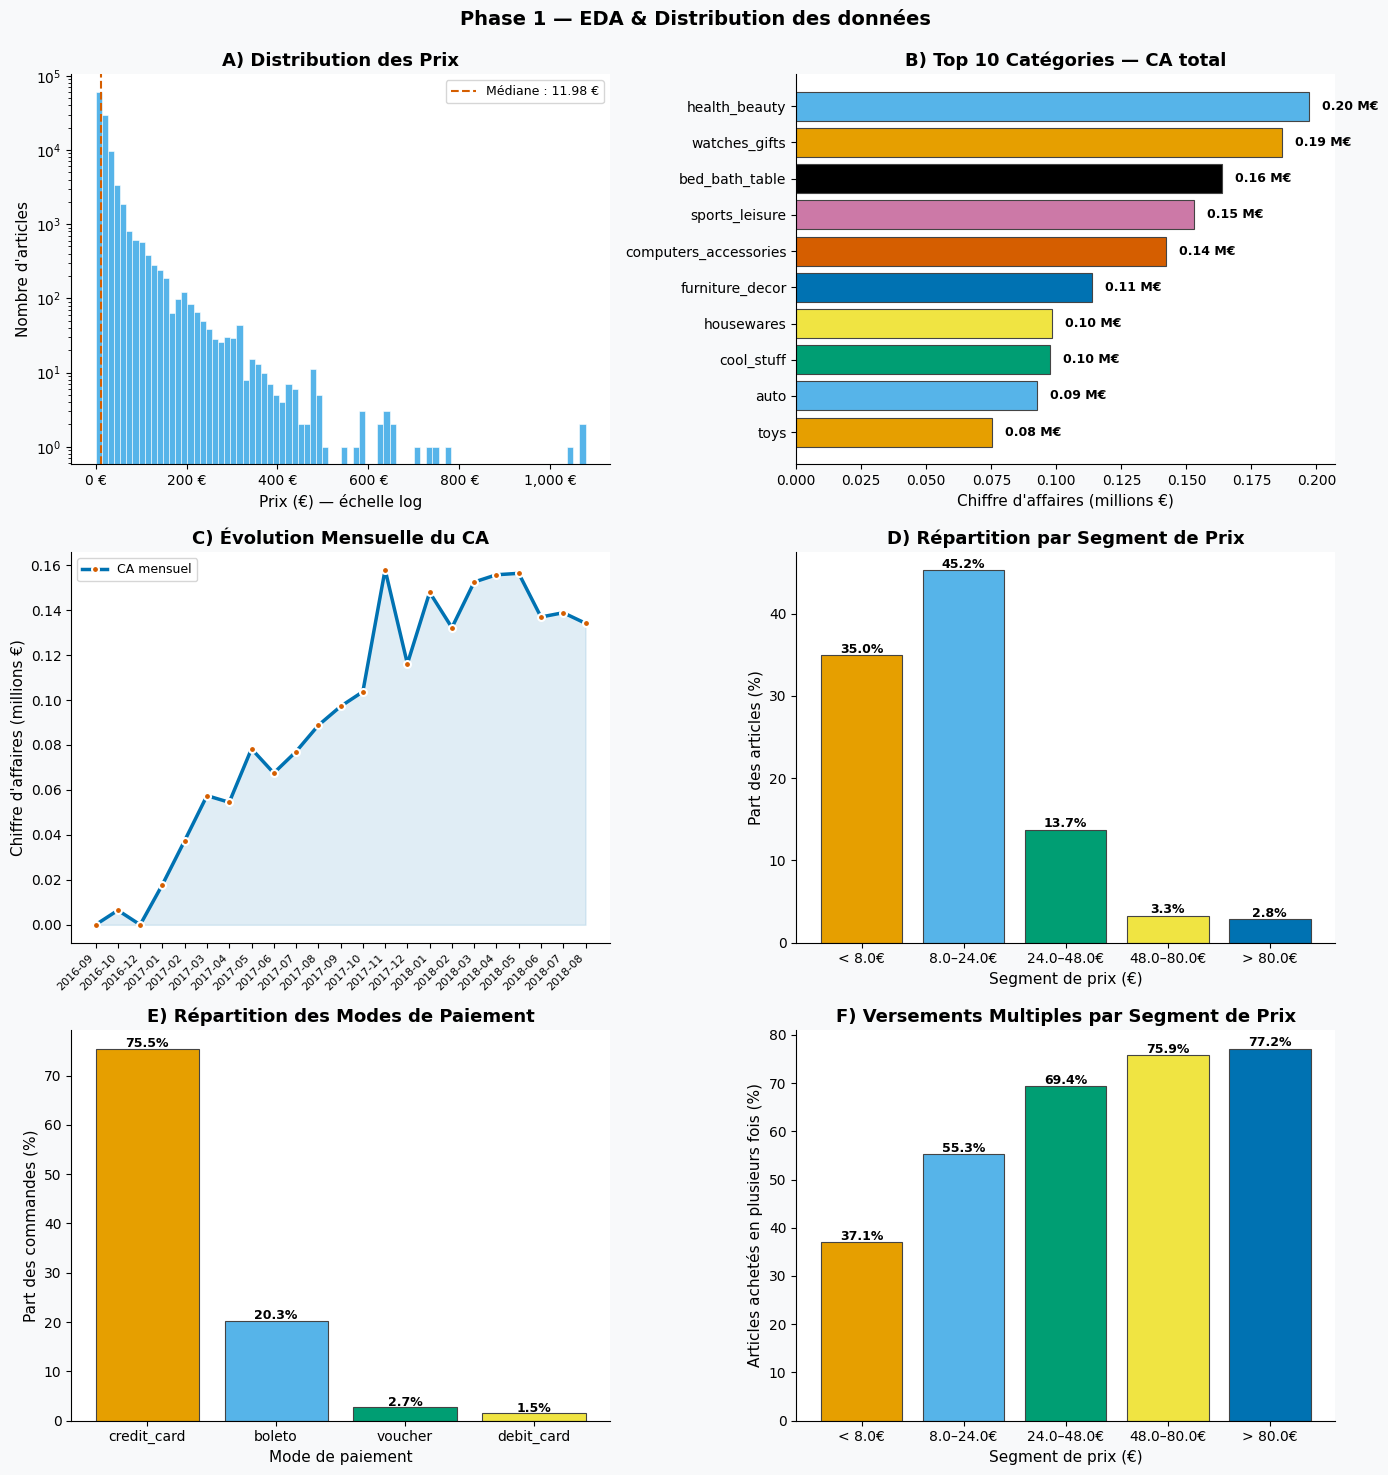

✅ Graphique sauvegardé : ../outputs/phase1_data_quality.png


In [10]:
# ── Agrégations intermédiaires (en €) ────────────────────
cat_agg = (
    df_final.groupby("category_en")
    .agg(total_revenue=("price_eur", "sum"), avg_price=("price_eur", "mean"),
         nb_items=("order_id", "count"))
    .sort_values("total_revenue", ascending=False)
    .reset_index()
)
monthly = (
    df_final.groupby("month_label")
    .agg(total_revenue=("price_eur", "sum"), nb_orders=("order_id", "nunique"))
    .reset_index().sort_values("month_label")
)
seg_agg = (
    df_final.groupby("price_segment_eur", observed=True)
    .agg(nb_items=("order_id", "count"),
         installment_rate=("is_installment", "mean"))
    .reset_index()
)
seg_agg["pct"] = seg_agg["nb_items"] / seg_agg["nb_items"].sum() * 100
pay_agg = df_final["payment_type"].value_counts(normalize=True).mul(100).round(1)

# ── Figure ────────────────────────────────────────────────
fig, axes = plt.subplots(3, 2, figsize=(14, 15))
fig.suptitle("Phase 1 — EDA & Distribution des données\n",
             fontsize=14, fontweight="bold")

# A) Distribution des prix en €
ax = axes[0, 0]
ax.hist(df_final["price_eur"], bins=80, color=PALETTE[1], edgecolor="white", lw=0.4)
ax.set_xlabel("Prix (€) — échelle log")
ax.set_ylabel("Nombre d'articles")
ax.set_title("A) Distribution des Prix")
ax.set_yscale("log")
ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x:,.0f} €"))
med = df_final["price_eur"].median()
ax.axvline(med, color=PALETTE[5], lw=1.5, linestyle="--", label=f"Médiane : {med:.2f} €")
ax.legend(fontsize=9)

# B) Top 10 catégories par CA en €
ax = axes[0, 1]
top10 = cat_agg.head(10).sort_values("total_revenue")
bars = ax.barh(
    top10["category_en"], top10["total_revenue"] / 1e6,
    color=[PALETTE[i % len(PALETTE)] for i in range(len(top10))],
    edgecolor="#444444", linewidth=0.8
)
ax.set_xlabel("Chiffre d'affaires (millions €)")
ax.set_title("B) Top 10 Catégories — CA total")
for bar, val in zip(bars, top10["total_revenue"] / 1e6):
    ax.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height() / 2,
            f"{val:.2f} M€", va="center", fontsize=9, fontweight="bold")

# C) Évolution mensuelle du CA en €
ax = axes[1, 0]
x = range(len(monthly))
ax.plot(x, monthly["total_revenue"] / 1e6,
        color=PALETTE[4], lw=2.5, marker="o", ms=5,
        markerfacecolor=PALETTE[5], markeredgecolor="white", markeredgewidth=1.5,
        label="CA mensuel")
ax.fill_between(x, monthly["total_revenue"] / 1e6, alpha=0.12, color=PALETTE[4])
ax.set_xticks(x)
ax.set_xticklabels(monthly["month_label"], rotation=45, ha="right", fontsize=8)
ax.set_ylabel("Chiffre d'affaires (millions €)")
ax.set_title("C) Évolution Mensuelle du CA")
ax.legend(fontsize=9)

# D) Segments de prix en €
ax = axes[1, 1]
bars2 = ax.bar(
    seg_agg["price_segment_eur"].astype(str), seg_agg["pct"],
    color=[PALETTE[i] for i in range(len(seg_agg))],
    edgecolor="#444444", linewidth=0.8
)
ax.set_xlabel("Segment de prix (€)")
ax.set_ylabel("Part des articles (%)")
ax.set_title("D) Répartition par Segment de Prix")
for bar, val in zip(bars2, seg_agg["pct"]):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.3,
            f"{val:.1f}%", ha="center", fontsize=9, fontweight="bold")

# E) Modes de paiement
ax = axes[2, 0]
bars3 = ax.bar(
    pay_agg.index, pay_agg.values,
    color=[PALETTE[i % len(PALETTE)] for i in range(len(pay_agg))],
    edgecolor="#444444", linewidth=0.8
)
ax.set_xlabel("Mode de paiement")
ax.set_ylabel("Part des commandes (%)")
ax.set_title("E) Répartition des Modes de Paiement")
for bar, val in zip(bars3, pay_agg.values):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.3,
            f"{val:.1f}%", ha="center", fontsize=9, fontweight="bold")

# F) Taux de versements multiples par segment
ax = axes[2, 1]
bars4 = ax.bar(
    seg_agg["price_segment_eur"].astype(str),
    seg_agg["installment_rate"] * 100,
    color=[PALETTE[i] for i in range(len(seg_agg))],
    edgecolor="#444444", linewidth=0.8
)
ax.set_xlabel("Segment de prix (€)")
ax.set_ylabel("Articles achetés en plusieurs fois (%)")
ax.set_title("F) Versements Multiples par Segment de Prix")
for bar, val in zip(bars4, seg_agg["installment_rate"] * 100):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5,
            f"{val:.1f}%", ha="center", fontsize=9, fontweight="bold")

plt.tight_layout()
plot_path = os.path.join(IMG_OUT, "phase1_data_quality.png")
plt.savefig(plot_path, dpi=150, bbox_inches="tight")
plt.show()
print(f"✅ Graphique sauvegardé : {plot_path}")

---
## 8. Export

Export en deux formats :
- **CSV** → source de données pour Power BI
- **Excel multi-onglets** → livrable lisible pour les parties prenantes (Finance, Category Managers)

In [13]:
# ── CSV ───────────────────────────────────────────────────
csv_path = os.path.join(DATA_OUT, "olist_pricing_dataset.csv")
df_final.to_csv(csv_path, index=False, encoding="utf-8-sig")
print(f"✅ CSV exporté     : {csv_path}")

# ── Excel multi-onglets ───────────────────────────────────
xlsx_path = os.path.join(DATA_OUT, "olist_pricing_dataset.xlsx")

monthly_full = (
    df_final.groupby("month_label")
    .agg(nb_orders=("order_id", "nunique"), total_revenue=("price", "sum"),
         total_margin=("estimated_margin", "sum"), avg_price=("price", "mean"))
    .round(2).reset_index().sort_values("month_label")
)
seg_full = (
    df_final.groupby("price_segment", observed=True)
    .agg(nb_items=("order_id", "count"), total_revenue=("price", "sum"),
         avg_review=("review_score_avg", "mean"),
         installment_rate=("is_installment", "mean"))
    .round(2).reset_index()
)
pay_full = (
    df_final.groupby("payment_type")
    .agg(nb_orders=("order_id", "nunique"), total_value=("payment_value", "sum"),
         avg_installments=("payment_installments", "mean"))
    .round(2).reset_index().sort_values("total_value", ascending=False)
)

with pd.ExcelWriter(xlsx_path, engine="openpyxl") as writer:
    df_final.to_excel(writer,     sheet_name="Raw_Data",         index=False)
    cat_agg.to_excel(writer,      sheet_name="By_Category",      index=False)
    monthly_full.to_excel(writer, sheet_name="Monthly_Trend",    index=False)
    seg_full.to_excel(writer,     sheet_name="By_Price_Segment", index=False)
    pay_full.to_excel(writer,     sheet_name="By_Payment_Type",  index=False)

print(f"✅ Excel exporté   : {xlsx_path} (5 onglets)")

✅ CSV exporté     : ../data/processed/olist_pricing_dataset.csv
✅ Excel exporté   : ../data/processed/olist_pricing_dataset.xlsx (5 onglets)


In [17]:
# ── Résumé final ──────────────────────────────────────────
print("=" * 55)
print("✅ PHASE 1 TERMINÉE — Résumé")
print("=" * 55)
print(f"  Lignes finales         : {len(df_final):,}")
print(f"  Colonnes               : {df_final.shape[1]}")
print(f"  Catégories produit     : {df_final['category_en'].nunique()}")
print(f"  États vendeurs         : {df_final['seller_state'].nunique()}")
print(f"  États clients          : {df_final['customer_state'].nunique()}")
print(f"  Modes de paiement      : {df_final['payment_type'].nunique()}")
print(f"  Période couverte       : {df_final['month_label'].min()} → {df_final['month_label'].max()}")
print(f"  Prix médian            : {df_final['price_eur'].median():.2f} €")
print(f"  CA total estimé        : {df_final['price_eur'].sum():,.0f} €")
print(f"  Marge totale estimée   : {df_final['estimated_margin_eur'].sum():,.0f} €")
print(f"  % achats en versements : {df_final['is_installment'].mean()*100:.1f}%")

✅ PHASE 1 TERMINÉE — Résumé
  Lignes finales         : 110,197
  Colonnes               : 33
  Catégories produit     : 73
  États vendeurs         : 22
  États clients          : 27
  Modes de paiement      : 4
  Période couverte       : 2016-09 → 2018-08
  Prix médian            : 11.98 €
  CA total estimé        : 2,115,319 €
  Marge totale estimée   : 951,912 €
  % achats en versements : 52.1%
